###                     CLASSIFICATION OF ORTHOPEDIC SPINE ALIGNMENT.

Pain, numbness and severe medical conditions result from spine injuries, misalignment, or herniated discs.  The classification of a patient's condition affects the treatment they receive and outcomes for their future.  Medical professionals use a grading system based on measurements of the spine and pelvis to communicate the condition and severity of misalignment or injury and use various other measurements to classify Grade I patients, separating the normal from abnormal for low-grade misalignement.  For patients with pain, the accuracy in diagnosis is important in receiving the correct treatment, approval for health insurance coverage, and prevention of further damage.  Kaggle has provided a robust set of 6 othopedic measurements (features) that we will use to create a predictive model to classify results accurately.  

It is helpful to understand what the degree of Spondylolisthesis is reporting when exploring the data.  Spondylolisthesis is a shift in the alignment of the spine.  The images below will describe what the data in "degree of spondylolisthesis" means and how it is calculated.<br><br>Grade I: 0-25%<br>Grade II: 25-50%<br>Grade III: 50-75%<br>Grade IV: 75-100%<br>Grade V: greater than 100%

![Spondylolethesis.PNG](attachment: Spondylolethesis.PNG)

In the data analysis below you will see that determining the Normal versus Abnormal results is clear for degrees above 25%.  However, within the Grade I from 0-25% there are varying results.  Within the Grade I category there is abnormal, herniated disc, and spondylolisthesis. We explore the additional features to determine if these can used to create a high confidence of prediciton.

## Data Cleaning


<b>Data Description:</b>  There are 2 files for this project, described as identical except for the "class" column in each.  <br> One file classifies the measurements into 1) normal and 2) abnormal, while the second file categorizes more deeply into 1) normal, 2) hernia, and 2) spondylolisthesis.<br><br>
<b>Validation:</b>  Exploration confirms the files appear to be identical.  The columns are the same, the number of unique values and total values are the same, and the mean & standard deviations of the values are the same, except for abnormal values in 'class', which, as expected, has the "abnormal" values of the one file, categorized into "hernia", and "spondylolishesis" in the other file.<br><br>
<b>Null Values:</b>  There are no null values, if there were I would have removed these records only if there NAN's within a feature we plan to use, after testing for confidence this decision would be made.  With an objective of classification based on multiple feaatures we cannot fill these values and be confident of the validity.<br><br>
<b>Duplicates:</b>  No reason to address single column identical values for this case, they are actually expected for medical measurements and should be left.  Only duplicates of complete rows should be removed as these can be assumed to be in error, the probability of a patient having all identical measurements is low.<br><br>
<b>Outlier's:</b>  Outlier's identified for any degree above 360 and removed.<br>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from numpy.random import seed
from scipy.stats import gamma, poisson

import pymc3 as pm
import arviz as az

<b> Load files and visually compare - they should be identical</b>

In [2]:
classify = pd.read_csv('Data/weka2c.csv')
classify.info()
classify.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 310 entries, 0 to 309
Data columns (total 7 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   pelvic_incidence          310 non-null    float64
 1   pelvic_tilt numeric       310 non-null    float64
 2   lumbar_lordosis_angle     310 non-null    float64
 3   sacral_slope              310 non-null    float64
 4   pelvic_radius             310 non-null    float64
 5   degree_spondylolisthesis  310 non-null    float64
 6   class                     310 non-null    object 
dtypes: float64(6), object(1)
memory usage: 17.1+ KB


,pelvic_incidence,pelvic_tilt numeric,lumbar_lordosis_angle,sacral_slope,pelvic_radius,degree_spondylolisthesis
count,310.000000,310.000000,310.000000,310.000000,310.000000,310.000000
mean,60.496653,17.542822,51.930930,42.953831,117.920655,26.296694
std,17.236520,10.008330,18.554064,13.423102,13.317377,37.559027
min,26.147921,-6.554948,14.000000,13.366931,70.082575,-11.058179
25%,46.430294,10.667069,37.000000,33.347122,110.709196,1.603727
50%,58.691038,16.357689,49.562398,42.404912,118.268178,11.767934
75%,72.877696,22.120395,63.000000,52.695888,125.467674,41.287352
max,129.834041,49.431864,125.742385,121.429566,163.071041,418.543082


In [3]:
# Compare values to previous files "weka2c", they should be identical.....
category = pd.read_csv('Data/weka3c.csv')
category.info()
category.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 310 entries, 0 to 309
Data columns (total 7 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   pelvic_incidence          310 non-null    float64
 1   pelvic_tilt               310 non-null    float64
 2   lumbar_lordosis_angle     310 non-null    float64
 3   sacral_slope              310 non-null    float64
 4   pelvic_radius             310 non-null    float64
 5   degree_spondylolisthesis  310 non-null    float64
 6   class                     310 non-null    object 
dtypes: float64(6), object(1)
memory usage: 17.1+ KB


,pelvic_incidence,pelvic_tilt,lumbar_lordosis_angle,sacral_slope,pelvic_radius,degree_spondylolisthesis
count,310.000000,310.000000,310.000000,310.000000,310.000000,310.000000
mean,60.496653,17.542822,51.930930,42.953831,117.920655,26.296694
std,17.236520,10.008330,18.554064,13.423102,13.317377,37.559027
min,26.147921,-6.554948,14.000000,13.366931,70.082575,-11.058179
25%,46.430294,10.667069,37.000000,33.347122,110.709196,1.603727
50%,58.691038,16.357689,49.562398,42.404912,118.268178,11.767934
75%,72.877696,22.120395,63.000000,52.695888,125.467674,41.287352
max,129.834041,49.431864,125.742385,121.429566,163.071041,418.543082


In [4]:
print(classify.nunique())

pelvic_incidence            310
pelvic_tilt numeric         310
lumbar_lordosis_angle       280
sacral_slope                281
pelvic_radius               310
degree_spondylolisthesis    310
class                         2
dtype: int64


In [5]:
print(category.nunique())

pelvic_incidence            310
pelvic_tilt                 310
lumbar_lordosis_angle       280
sacral_slope                281
pelvic_radius               310
degree_spondylolisthesis    310
class                         3
dtype: int64


In [6]:
classify["class"].value_counts()   # Count Class targets

Abnormal    210
Normal      100
Name: class, dtype: int64

In [7]:
category["class"].value_counts()    # Count categorization targets

Spondylolisthesis    150
Normal               100
Hernia                60
Name: class, dtype: int64

In [8]:
df2vals = classify["degree_spondylolisthesis"]
df3vals = category["degree_spondylolisthesis"]

     pelvic_incidence  pelvic_tilt numeric  lumbar_lordosis_angle  \
0           63.027818            22.552586              39.609117   
1           39.056951            10.060991              25.015378   
2           68.832021            22.218482              50.092194   
3           69.297008            24.652878              44.311238   
4           49.712859             9.652075              28.317406   
..                ...                  ...                    ...   
305         47.903565            13.616688              36.000000   
306         53.936748            20.721496              29.220534   
307         61.446597            22.694968              46.170347   
308         45.252792             8.693157              41.583126   
309         33.841641             5.073991              36.641233   

     sacral_slope  pelvic_radius  degree_spondylolisthesis     class  
0       40.475232      98.672917                 -0.254400  Abnormal  
1       28.995960     114.405

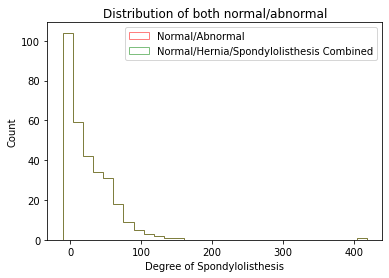

In [9]:
# The plot shows all lines in brown, indicating both data points overlap
# Note that the overall data is exponential in shape.
_ = plt.hist(df2vals, histtype = 'step', bins=30, alpha = 0.5, color = 'red', label = 'Normal/Abnormal')
_ = plt.hist(df3vals, histtype = 'step', bins=30, alpha = 0.5, color ='green', label = 'Normal/Hernia/Spondylolisthesis Combined')
_ = plt.title("Distribution of both normal/abnormal")
_ = plt.xlabel("Degree of Spondylolisthesis")
_ = plt.ylabel("Count")
_ = plt.legend()

In [10]:
#  Merge the files and rename the columns for ease-of-use
#  Note from now on the only separation of the 2 files is the 2 columns "category" and "class"
df = pd.merge(category, classify, on='degree_spondylolisthesis', how='right')
df2 = df[['pelvic_incidence_x', 'pelvic_tilt', 'lumbar_lordosis_angle_x', 'sacral_slope_x', 'pelvic_radius_x', 'degree_spondylolisthesis','class_x','class_y']]
df = df2.rename(columns = {'pelvic_incidence_x':'incidence', 'pelvic_tilt': 'tilt', 'lumbar_lordosis_angle_x': 'angle', 'sacral_slope_x': 'slope', 'pelvic_radius_x': 'radius', 'degree_spondylolisthesis' : 'degree', 'class_x' : 'category', 'class_y':'class'})
print(df.count(axis='rows'))

incidence    310
tilt         310
angle        310
slope        310
radius       310
degree       310
category     310
class        310
dtype: int64


In [11]:
# slice and plot "normal" data from both the category and class
class_norm = df.loc[df['class'] == 'Normal']['degree']
cat_norm = df.loc[df['category'] == 'Normal']['degree']

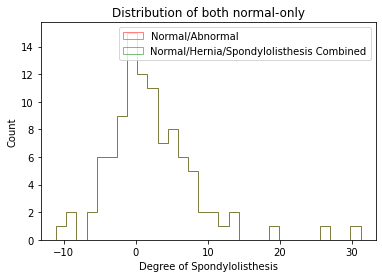

In [12]:
# The plot shows all lines in brown, indicating both data points overlap
# Note that the overall data is exponential in shape.
_ = plt.hist(class_norm, histtype = 'step', bins=30, alpha = 0.5, color = 'red', label = 'Normal/Abnormal')
_ = plt.hist(cat_norm, histtype = 'step', bins=30, alpha = 0.5, color ='green', label = 'Normal/Hernia/Spondylolisthesis Combined')
_ = plt.title("Distribution of both normal-only")
_ = plt.xlabel("Degree of Spondylolisthesis")
_ = plt.ylabel("Count")
_ = plt.legend()

In [13]:
# slice and plot "abnormal" data from both the category and class
class_abn = df.loc[df['class'] == 'Abnormal']['degree']
cat_abn = df.loc[df['category'] != 'Normal']['degree']

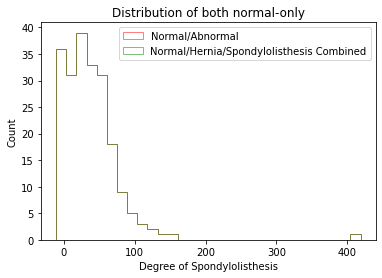

In [14]:
# The plot shows all lines in brown, indicating both data points overlap
# Note that the overall data is exponential in shape.
_ = plt.hist(class_abn, histtype = 'step', bins=30, alpha = 0.5, color = 'red', label = 'Normal/Abnormal')
_ = plt.hist(cat_abn, histtype = 'step', bins=30, alpha = 0.5, color ='green', label = 'Normal/Hernia/Spondylolisthesis Combined')
_ = plt.title("Distribution of both normal-only")
_ = plt.xlabel("Degree of Spondylolisthesis")
_ = plt.ylabel("Count")
_ = plt.legend()

In [15]:
# remove the ouliers, values > 360
df = df.loc[df['degree'] <= 360].copy(deep=True)

#### Analysis <br>


In [16]:
# slice"abnormal" data
classified = df.loc[df['class'] == 'Abnormal']['degree']
hernia = df.loc[df['category'] == 'Hernia']['degree']
spondylolisthesis = df.loc[df['category'] == 'Spondylolisthesis']['degree']

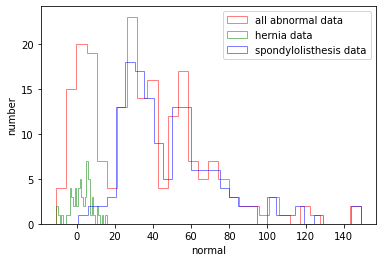

In [17]:
# The plot of abnormal results
_ = plt.hist(classified, histtype = 'step', bins=30, alpha = 0.5, color = 'red', label = 'all abnormal data')
_ = plt.hist(hernia, histtype = 'step', bins=30, alpha=0.5, color ='green', label = 'hernia data')
_ = plt.hist(spondylolisthesis, histtype = 'step', bins=30, alpha=0.5, color ='blue', label = 'spondylolisthesis data')
_ = plt.xlabel("normal")
_ = plt.ylabel("number")
_ = plt.legend()

<b> Below we see that any degree of spondylolithesis greater than 30 is automatically an abnormal result.<br>  Also we see the normal results are distributed normally around the 0 value, while abnormal results are shaped more exponentially leaning right.</b>

(array([39., 30., 50., 32., 29., 15.,  5.,  4.,  3.,  2.]),
 array([-10.67587083,   5.26708734,  21.21004552,  37.15300369,
         53.09596186,  69.03892004,  84.98187821, 100.92483638,
        116.86779455, 132.81075273, 148.7537109 ]),
 [<matplotlib.patches.Polygon at 0x1a2a0324d0>])

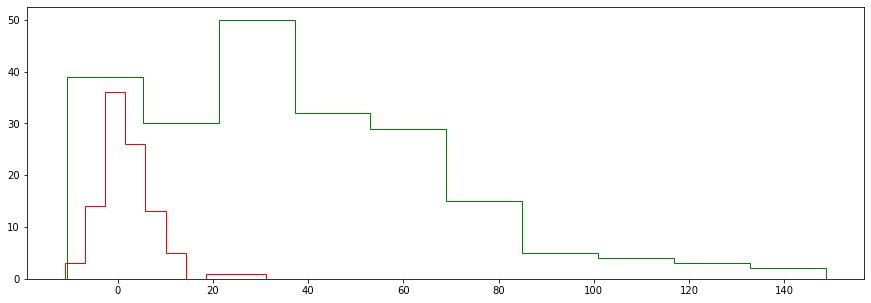

In [18]:
normal = df[df['class'] == 'Normal']['degree']
abnormal = df[df['class'] == 'Abnormal']['degree']

plt.figure(figsize=[15,5])
plt.hist(normal, histtype='step', color = 'red')
plt.hist(abnormal, histtype='step', color = 'green')

<b> The correlations in the below pairplot show many noteworthy items.  <br> First, looking at the degree column we can see again that values above 30 are clearly abnormal and normal is strictly a normal shape around 0 <br>
Secondly, all abnormal values tend to be greater than normal in values for features such as angle, tilt, and incidence, EXCEPT for radius which tends to me the opposite, lower or equal in value to normals.  

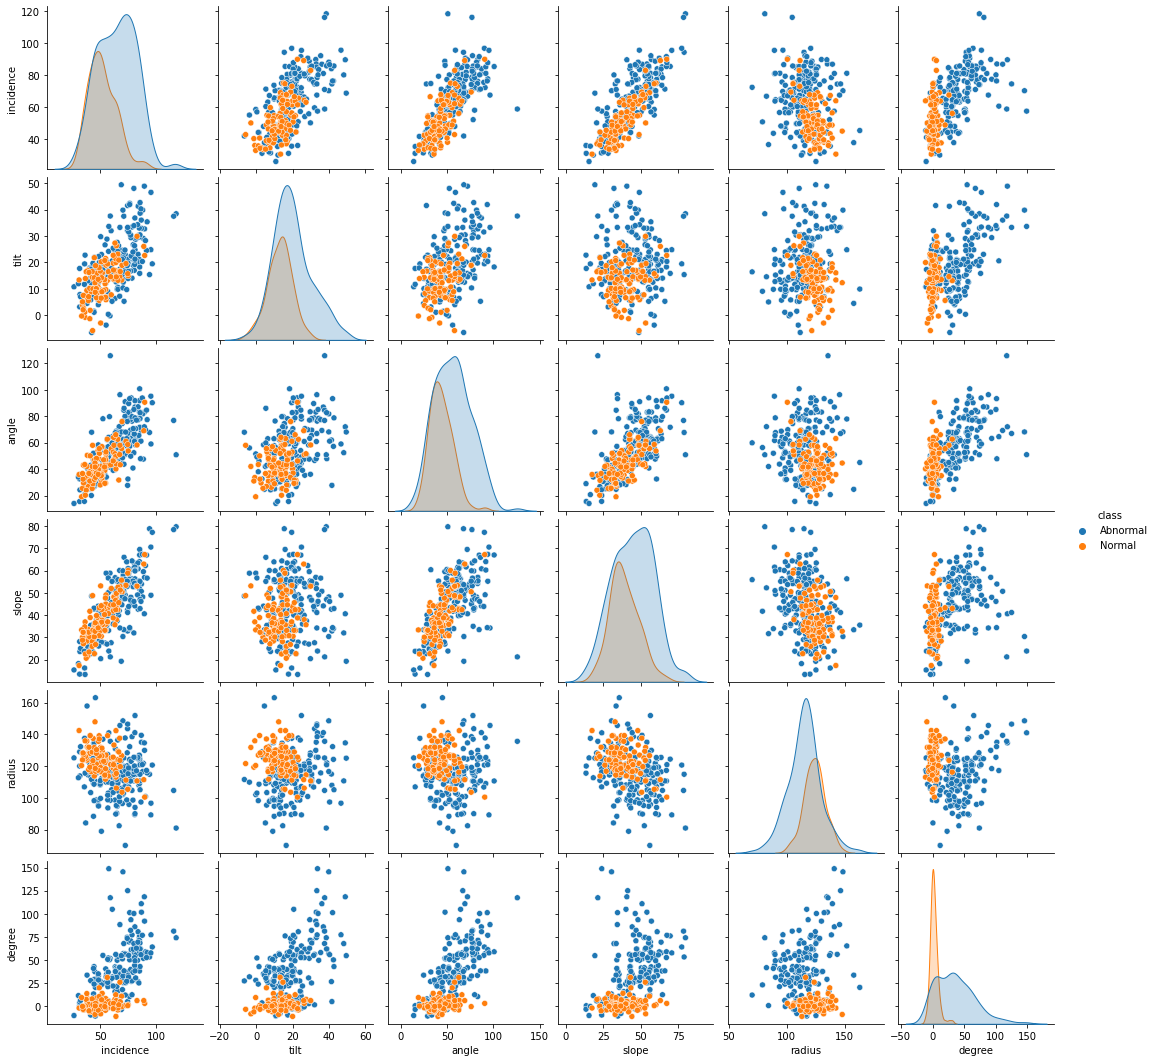

In [19]:
sns.pairplot(df, hue="class")
plt.show()

In [20]:
print(df.corr())

           incidence      tilt     angle     slope    radius    degree
incidence   1.000000  0.659553  0.739510  0.804772 -0.244163  0.642157
tilt        0.659553  1.000000  0.432809  0.084618  0.030461  0.534300
angle       0.739510  0.432809  1.000000  0.638521 -0.080903  0.672138
slope       0.804772  0.084618  0.638521  1.000000 -0.347722  0.429320
radius     -0.244163  0.030461 -0.080903 -0.347722  1.000000 -0.000023
degree      0.642157  0.534300  0.672138  0.429320 -0.000023  1.000000


In [29]:
df['class']=df['class'].map({'Normal':0,'Abnormal':1})
abn = df[(df['class'] != 0)]
nor = df[(df['class'] == 0)]

<class 'pandas.core.frame.DataFrame'>


<b> Below is a comparison of Abnormal/Normal correlations with the 'degree' feature to compare the weights of the features on the most highly correlated feature. A comparison of the change of correlations between the classes suggests adding more weight to raius and degree could improve the model.

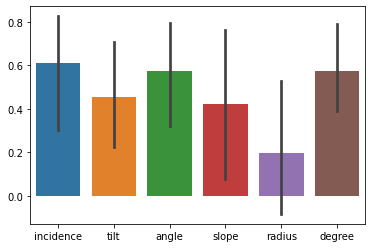

In [23]:
# Abnormal dataset correlation 
correlate = abn.corr()
correlate = correlate.drop(columns = ["class"])
correlate.sort_values(by = "degree",inplace=True)
ax = sns.barplot(data=correlate)

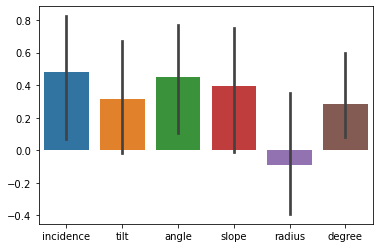

In [24]:
# Normal dataset correlations
corr2 = nor.corr()
corr2 = corr2.drop(columns = ["class"])
corr2.sort_values(by="degree", inplace=True)
ax = sns.barplot(data=corr2)

<b> Statistical inference analysis.  <br> To begin let's determine the shape of the distributions of the abnormal results.

In [165]:
abn = df[(df['class'] != 0)]
nor = df[(df['class'] == 0)]
abn = abn["degree"]
nor = nor["degree"]
n_abn = len(abn)
n_nor = len(nor)

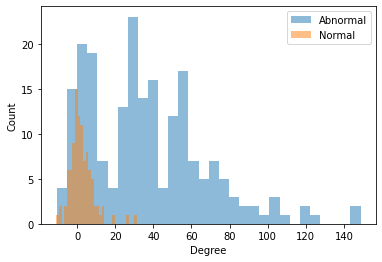

In [167]:
_ = plt.hist(abn, bins=30, alpha=0.5, label='Abnormal')
_ = plt.hist(nor, bins=30, alpha=0.5, label='Normal')
_ = plt.xlabel('Degree')
_ = plt.ylabel('Count')
_ = plt.legend()

In [213]:
alpha_est = np.mean(abn)**2 / np.var(abn)
beta_est = np.var(abn) / np.mean(abn)
alpha_est, beta_est

(1.347800055346333, 26.67744450790181)

In [214]:
seed(47)
abn_rvs = gamma(alpha_est, scale=beta_est).rvs(n_abn)

<b> The graph below shows the orinial abnormal data compared to the random variates using an eponential scale

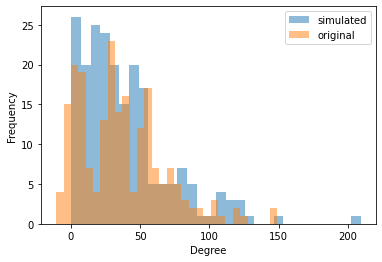

In [319]:
_ = plt.hist(abn_rvs, bins=30, alpha=0.5, label='simulated')
_ = plt.hist(abn, bins=30, alpha=0.5, label='original')
_ = plt.xlabel('Degree')
_ = plt.ylabel('Frequency')
_ = plt.legend()